### Build movie recomender system

[ Link to article](https://towardsdatascience.com/hands-on-content-based-recommender-system-using-python-1d643bf314e4)

[Link to dataset](https://www.kaggle.com/datasets/harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows?resource=download)

Objective of this notebook is to explore one of the ways to build a recomendation engine using the movies dataset. In a nutshell, a recommender engine is a tool that suggests you the next content given what you have already seen and liked. Companies like Spotify, Netflix or Youtube use recommender systems to suggest you the next video or song to watch given what you have already seen or listened to.
In this notebook we use the movies data to suggest similar movies based on the movies that a user has watched.

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from sentence_transformers import SentenceTransformer
#pip install --ignore-installed --user sentence-transformers
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.serif'] = 'Ubuntu' 
plt.rcParams['font.monospace'] = 'Ubuntu Mono' 
plt.rcParams['font.size'] = 14 
plt.rcParams['axes.labelsize'] = 12 
plt.rcParams['axes.labelweight'] = 'bold' 
plt.rcParams['axes.titlesize'] = 12 
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12 
plt.rcParams['legend.fontsize'] = 12 
plt.rcParams['figure.titlesize'] = 12 
plt.rcParams['image.cmap'] = 'jet' 
plt.rcParams['image.interpolation'] = 'none' 
plt.rcParams['figure.figsize'] = (12, 10) 
plt.rcParams['axes.grid']=True
plt.rcParams['lines.linewidth'] = 2 
plt.rcParams['lines.markersize'] = 8
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd: goldenrod', 'xkcd:cadet blue',
'xkcd:scarlet']

In [21]:
def read_data(path_to_csv_file):
    '''
    Reads csv files from specified paths

    Parameters:
            path to csv file locations
    Returns:
            dataframes of imported csv files
    '''
    # Read CSV files
    df = pd.read_csv(path_to_csv_file)
    
    return df

# call the function to import train data - update with relevant paths
movies_data = read_data('C:/Users/leemn/Downloads/imdb_top_1000.csv')

In [22]:
def df_snapshot(df):
    '''
    Returns top 5 rows of the dataframe.

    Parameters:
        df (DataFrame): Pandas dataframe
    '''
    return display(df.head())

print(f'movies_data:')
df_snapshot(movies_data)

movies_data:


,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469"
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"


In [23]:
def data_types(df):
    '''
    Returns datatype of fields in a dataframe.

    Parameters:
        df (DataFrame): Pandas dataframe
    '''
    return df.info()

print(f'movies_data:')
data_types(movies_data)

movies_data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Poster_Link    1000 non-null   object 
 1   Series_Title   1000 non-null   object 
 2   Released_Year  1000 non-null   object 
 3   Certificate    899 non-null    object 
 4   Runtime        1000 non-null   object 
 5   Genre          1000 non-null   object 
 6   IMDB_Rating    1000 non-null   float64
 7   Overview       1000 non-null   object 
 8   Meta_score     843 non-null    float64
 9   Director       1000 non-null   object 
 10  Star1          1000 non-null   object 
 11  Star2          1000 non-null   object 
 12  Star3          1000 non-null   object 
 13  Star4          1000 non-null   object 
 14  No_of_Votes    1000 non-null   int64  
 15  Gross          831 non-null    object 
dtypes: float64(2), int64(1), object(13)
memory usage: 125.1+ KB


In [24]:
def null_checker(df):
    '''
    Returns the count of rows found in the data frame where there is a null present.

    Parameters:
        df (Dataframe): Pandas dataframe

    Returns:
        Prints the null count, null percentage, and row count per column.
    '''
    row_count = len(df)
    null_counts = df.isnull().sum().sort_values(ascending=False)
    null_percentages = (null_counts / row_count) * 100
    combined = pd.concat([null_counts, null_percentages], axis=1, keys=['Null Count', 'Null Percentage'])
    combined['Row Count'] = row_count
    print(combined)

print(f'movies_data:')
null_checker(movies_data)

movies_data:
               Null Count  Null Percentage  Row Count
Gross                 169             16.9       1000
Meta_score            157             15.7       1000
Certificate           101             10.1       1000
Poster_Link             0              0.0       1000
Series_Title            0              0.0       1000
Released_Year           0              0.0       1000
Runtime                 0              0.0       1000
Genre                   0              0.0       1000
IMDB_Rating             0              0.0       1000
Overview                0              0.0       1000
Director                0              0.0       1000
Star1                   0              0.0       1000
Star2                   0              0.0       1000
Star3                   0              0.0       1000
Star4                   0              0.0       1000
No_of_Votes             0              0.0       1000


### The Approach
When working with textual data the first thing to do is to convert this text into numbers. More precisely we are converting a string of text into a vector. In our case we will use the vectorize test to find the similarity between two vectors.Then use the (5) most similar vectors with the one we are considering.

Let’s say x and y are two components. If a movie talks about science, space and rockets and another one talks more or less about the same stuff, we expect the two vectors to be close, like the blue ones below.
On the other hand, if the other movie is about a love story we will expect this vector to be far away, like the red and the blue ones.

Example below:
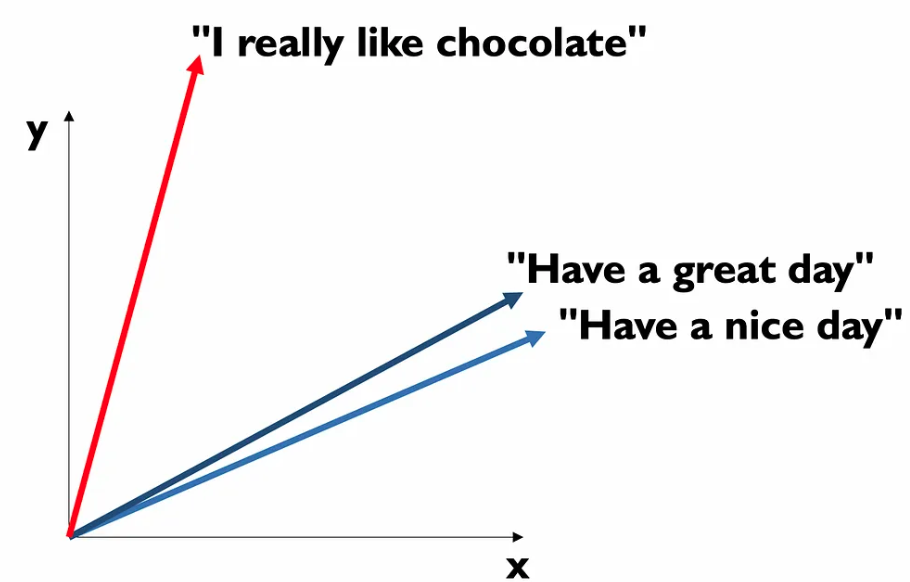




- We will use BERT (Bidirectional Encoder Representations from Transformers) to convert our text into a vector
- Get the cosine similarity (the cosine of the angle between the two vectors) of a fixed movie (vector) and all the other ones
- Pick the movies (vectors) with the largest cosine similarity. We are going to pick 5 of them

In [25]:
# Convert text to vector
X = np.array(movies_data.Overview)
text_data = X
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(text_data, show_progress_bar=True)

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

### Cosine Similarity and Recommendation Function
- Cosine similarity measures the similarity between two vectors of an inner product space
- Compute the cosine similarity and the function that we’ll use to get our recommendations.



In [29]:
embed_data = embeddings
X = np.array(embed_data)

cos_sim_data = pd.DataFrame(cosine_similarity(X))

def give_recommendations(index,print_recommendation = False,print_recommendation_plots= False,print_genres =False):
  index_recomm =cos_sim_data.loc[index].sort_values(ascending=False).index.tolist()[1:6]
  movies_recomm =  movies_data['Series_Title'].loc[index_recomm].values
  result = {'Movies':movies_recomm,'Index':index_recomm}
  if print_recommendation==True:
    print('The watched movie is this one: %s \n'%(movies_data['Series_Title'].loc[index]))
    k=1
    for movie in movies_recomm:
      print('The number %i recommended movie is this one: %s \n'%(k,movie))
  if print_recommendation_plots==True:
    print('The plot of the watched movie is this one:\n %s \n'%(movies_data['Overview'].loc[index]))
    k=1
    for q in range(len(movies_recomm)):
      plot_q = movies_data['Overview'].loc[index_recomm[q]]
      print('The plot of the number %i recommended movie is this one:\n %s \n'%(k,plot_q))
      k=k+1
  if print_genres==True:
    print('The genres of the watched movie is this one:\n %s \n'%(movies_data['Genre'].loc[index]))
    k=1
    for q in range(len(movies_recomm)):
      plot_q = movies_data['Genre'].loc[index_recomm[q]]
      print('The plot of the number %i recommended movie is this one:\n %s \n'%(k,plot_q))
      k=k+1
  return result

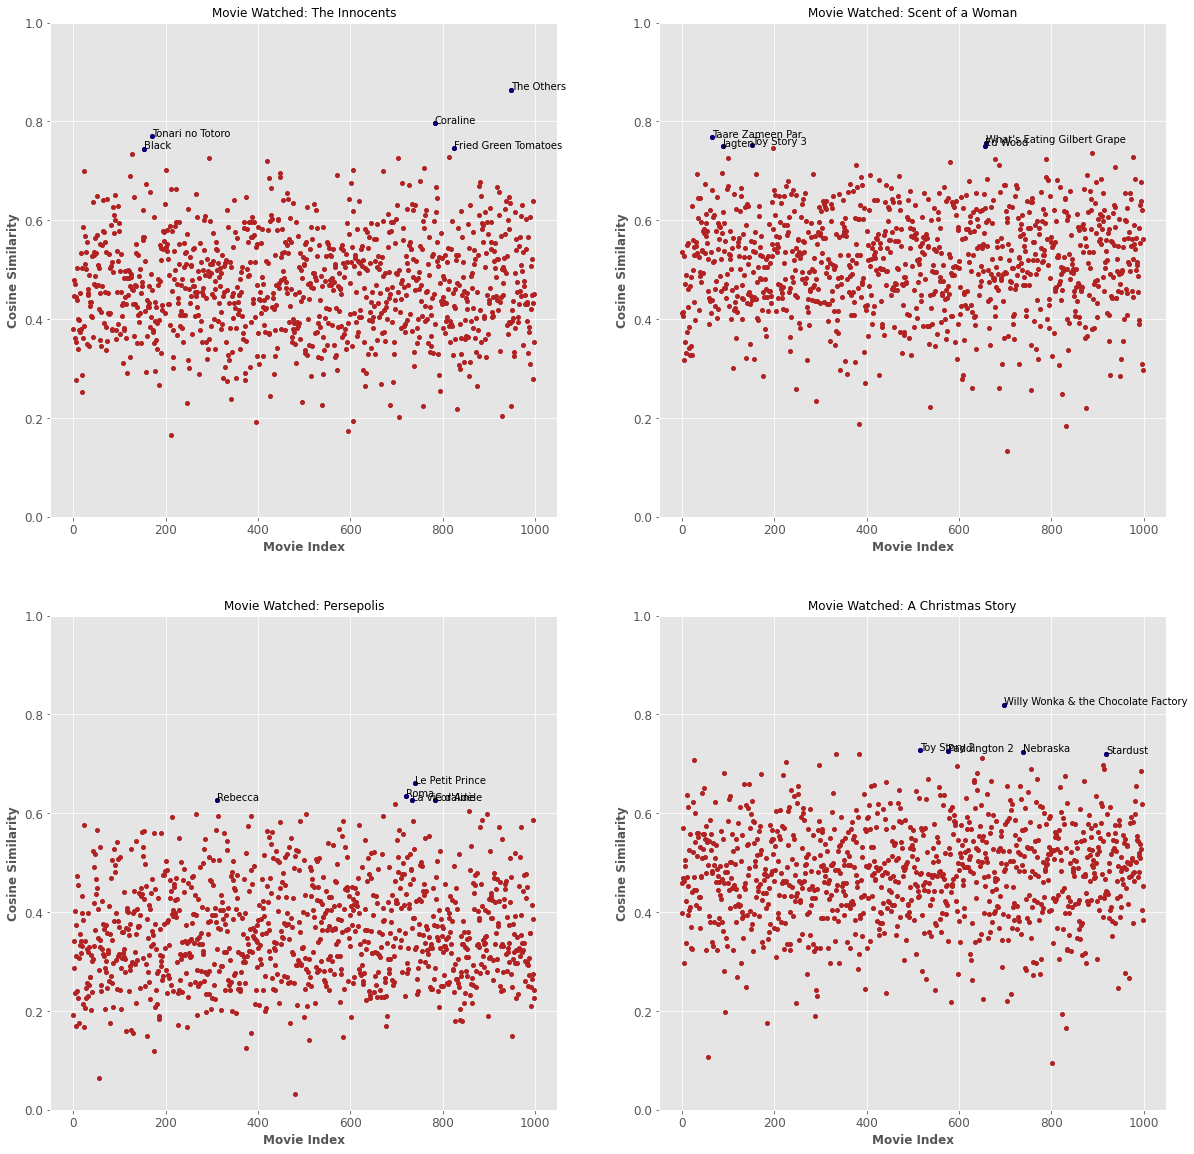

In [67]:
plt.figure(figsize=(20,20))
for q in range(1,5):
  plt.subplot(2,2,q)
  index = np.random.choice(np.arange(0,len(X)))
  to_plot_data = cos_sim_data.drop(index,axis=1)
  plt.plot(to_plot_data.loc[index],'.',color='firebrick')
  recomm_index = give_recommendations(index)
  x = recomm_index['Index']
  y = cos_sim_data.loc[index][x].tolist()
  m = recomm_index['Movies']
  plt.plot(x,y,'.',color='navy',label='Recommended Movies')
  plt.title('Movie Watched: '+movies_data['Series_Title'].loc[index])
  plt.xlabel('Movie Index')
  k=0
  for x_i in x:
    plt.annotate('%s'%(m[k]),(x_i,y[k]),fontsize=10)
    k=k+1

  plt.ylabel('Cosine Similarity')
  plt.ylim(0,1)

In [69]:
give_recommendations(2,True)

The watched movie is this one: The Dark Knight 

The number 1 recommended movie is this one: Joker 

The number 1 recommended movie is this one: Dirty Harry 

The number 1 recommended movie is this one: Batman Begins 

The number 1 recommended movie is this one: Guardians of the Galaxy 

The number 1 recommended movie is this one: Death Note: Desu nôto 



{'Movies': array(['Joker', 'Dirty Harry', 'Batman Begins', 'Guardians of the Galaxy',
        'Death Note: Desu nôto'], dtype=object),
 'Index': [33, 853, 155, 339, 762]}

In [70]:
give_recommendations(2,False,True)

The plot of the watched movie is this one:
 When the menace known as the Joker wreaks havoc and chaos on the people of Gotham, Batman must accept one of the greatest psychological and physical tests of his ability to fight injustice. 

The plot of the number 1 recommended movie is this one:
 In Gotham City, mentally troubled comedian Arthur Fleck is disregarded and mistreated by society. He then embarks on a downward spiral of revolution and bloody crime. This path brings him face-to-face with his alter-ego: the Joker. 

The plot of the number 2 recommended movie is this one:
 When a madman calling himself "the Scorpio Killer" menaces the city, tough-as-nails San Francisco Police Inspector "Dirty" Harry Callahan is assigned to track down and ferret out the crazed psychopath. 

The plot of the number 3 recommended movie is this one:
 After training with his mentor, Batman begins his fight to free crime-ridden Gotham City from corruption. 

The plot of the number 4 recommended movie is t

{'Movies': array(['Joker', 'Dirty Harry', 'Batman Begins', 'Guardians of the Galaxy',
        'Death Note: Desu nôto'], dtype=object),
 'Index': [33, 853, 155, 339, 762]}

In [71]:
give_recommendations(10,True,True)

The watched movie is this one: The Lord of the Rings: The Fellowship of the Ring 

The number 1 recommended movie is this one: The Lord of the Rings: The Return of the King 

The number 1 recommended movie is this one: Harry Potter and the Deathly Hallows: Part 2 

The number 1 recommended movie is this one: The Hobbit: An Unexpected Journey 

The number 1 recommended movie is this one: Star Wars: Episode VII - The Force Awakens 

The number 1 recommended movie is this one: The Hobbit: The Desolation of Smaug 

The plot of the watched movie is this one:
 A meek Hobbit from the Shire and eight companions set out on a journey to destroy the powerful One Ring and save Middle-earth from the Dark Lord Sauron. 

The plot of the number 1 recommended movie is this one:
 Gandalf and Aragorn lead the World of Men against Sauron's army to draw his gaze from Frodo and Sam as they approach Mount Doom with the One Ring. 

The plot of the number 2 recommended movie is this one:
 Harry, Ron, and Hermi

{'Movies': array(['The Lord of the Rings: The Return of the King',
        'Harry Potter and the Deathly Hallows: Part 2',
        'The Hobbit: An Unexpected Journey',
        'Star Wars: Episode VII - The Force Awakens',
        'The Hobbit: The Desolation of Smaug'], dtype=object),
 'Index': [5, 226, 618, 477, 609]}

In [72]:
give_recommendations(65,True,True,True)

The watched movie is this one: Taare Zameen Par 

The number 1 recommended movie is this one: Jagten 

The number 1 recommended movie is this one: What's Eating Gilbert Grape 

The number 1 recommended movie is this one: Scent of a Woman 

The number 1 recommended movie is this one: The Boy in the Striped Pyjamas 

The number 1 recommended movie is this one: Harry Potter and the Sorcerer's Stone 

The plot of the watched movie is this one:
 An eight-year-old boy is thought to be a lazy trouble-maker, until the new art teacher has the patience and compassion to discover the real problem behind his struggles in school. 

The plot of the number 1 recommended movie is this one:
 A teacher lives a lonely life, all the while struggling over his son's custody. His life slowly gets better as he finds love and receives good news from his son, but his new luck is about to be brutally shattered by an innocent little lie. 

The plot of the number 2 recommended movie is this one:
 A young man in a 

{'Movies': array(['Jagten', "What's Eating Gilbert Grape", 'Scent of a Woman',
        'The Boy in the Striped Pyjamas',
        "Harry Potter and the Sorcerer's Stone"], dtype=object),
 'Index': [88, 658, 398, 616, 947]}

In [75]:
recomm_list = []
for i in range(len(X)):
  recomm_i = give_recommendations(i)
  recomm_list.append(recomm_i['Movies'])
recomm_data = pd.DataFrame(recomm_list,columns=['First Recommendation','Second Recommendation','Third Recommendation','Fourth Recommendation','Fifth Recommendation'])
recomm_data['Watched Movie'] = movies_data['Series_Title']
recomm_data = recomm_data[['Watched Movie','First Recommendation','Second Recommendation','Third Recommendation','Fourth Recommendation','Fifth Recommendation']]
recomm_data.sample(frac=1).head()

,Watched Movie,First Recommendation,Second Recommendation,Third Recommendation,Fourth Recommendation,Fifth Recommendation
977,The Naked Gun: From the Files of Police Squad!,Lucky Number Slevin,The Bourne Ultimatum,The 39 Steps,The Fugitive,Vikram Vedha
960,Sleepers,Koe no katachi,Ondskan,Capharnaüm,Celda 211,The Boy in the Striped Pyjamas
35,The Intouchables,Sling Blade,Blue Velvet,Shine,Jurassic Park,"I, Daniel Blake"
112,The Sting,Mission: Impossible - Fallout,Mononoke-hime,The Avengers,Vikram Vedha,The Silence of the Lambs
492,"4 luni, 3 saptamâni si 2 zile",Viskningar och rop,Eastern Promises,Crimes and Misdemeanors,Pink,Män som hatar kvinnor


- This recommender system seem to be pretty accurate considering that it's a veru simple model. 
- eg  the movie that a user watched is thre following:

“ When the menace known as the Joker wreaks havoc and chaos on the people of Gotham, Batman must accept one of the greatest psychological and physical tests of his ability to fight injustice.”

- The first recommended movie is:

“In Gotham City, mentally troubled comedian Arthur Fleck is disregarded and mistreated by society. He then embarks on a downward spiral of revolution and bloody crime. This path brings him face-to-face with his alter-ego: the Joker.”

which are pretty the same and have the same genres